In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

import healpy as hp
import fitsio as ft
import numpy as np

import sys
sys.path.append('/home/mehdi/github/skymapper')
sys.path.append('/home/mehdi/github/LSSutils')
import skymapper as skm
import LSSutils.dataviz as dv

from LSSutils.utils import hpixsum, shiftra

In [2]:
plt.rc('font', family='serif', size=12)

In [3]:
dNGC = ft.read('/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_NGC_v7_2_0.1.dat.fits')
rNGC = ft.read('/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_NGC_v7_2_0.1.ran.fits')

dSGC = ft.read('/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_SGC_v7_2_0.1.dat.fits')
rSGC = ft.read('/home/mehdi/data/eboss/v7_2/0.1/eBOSS_QSO_clustering_SGC_v7_2_0.1.ran.fits')

data = np.concatenate([dNGC, dSGC])
random = np.concatenate([rNGC, rSGC])

In [20]:
nside  = 256
hpmap  = hpixsum(nside,  data['RA'], data['DEC'],
                 value=data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ'])
hpmapr = hpixsum(nside, random['RA'], random['DEC'], 
                 value=random['WEIGHT_CP']*random['WEIGHT_FKP']*random['WEIGHT_NOZ'])

In [21]:
mask = hpmapr != 0
meanran = np.mean(hpmapr[mask])
frac = hpmapr / meanran

hpmap[~mask] = np.nan
density = hpmap/(frac*hp.nside2pixarea(nside, degrees=True))

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [60]:
np.percentile(density[mask], [0, 10, 90, 100])

array([   0.        ,   26.34092531,  129.66963142, 4018.68303514])

In [90]:
help(fig.add_subplot)

Help on method add_subplot in module matplotlib.figure:

add_subplot(*args, **kwargs) method of matplotlib.figure.Figure instance
    Add an `~.axes.Axes` to the figure as part of a subplot arrangement.
    
    Call signatures::
    
       add_subplot(nrows, ncols, index, **kwargs)
       add_subplot(pos, **kwargs)
       add_subplot(ax)
       add_subplot()
    
    Parameters
    ----------
    *args
        Either a 3-digit integer or three separate integers
        describing the position of the subplot. If the three
        integers are *nrows*, *ncols*, and *index* in order, the
        subplot will take the *index* position on a grid with *nrows*
        rows and *ncols* columns. *index* starts at 1 in the upper left
        corner and increases to the right.
    
        *pos* is a three digit integer, where the first digit is the
        number of rows, the second the number of columns, and the third
        the index of the subplot. i.e. fig.add_subplot(235) is the same as


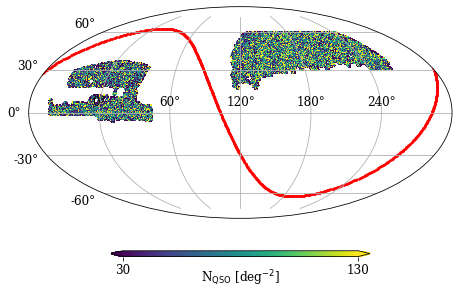

In [61]:
dv.mollview(density, 
            unit=r'N$_{{\rm QSO}}$ [deg$^{-2}$]', cmap=plt.cm.viridis, 
            vmin=30, vmax=130, colorbar=True, width=6, 
            extend='both', galaxy=True)

# plt.savefig('./figs/qso_0.1.pdf', bbox_inches='tight') # rasterized=True,
plt.savefig('./figs/qso_0.1.png', bbox_inches='tight', dpi=500) # rasterized=True,

optimizing parameters of Albers to minimize meanDistortion
best objective 0.021215 at Albers(4.460711848094176,41.91550943464491,36.791951673680906,51.708748474311136)


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


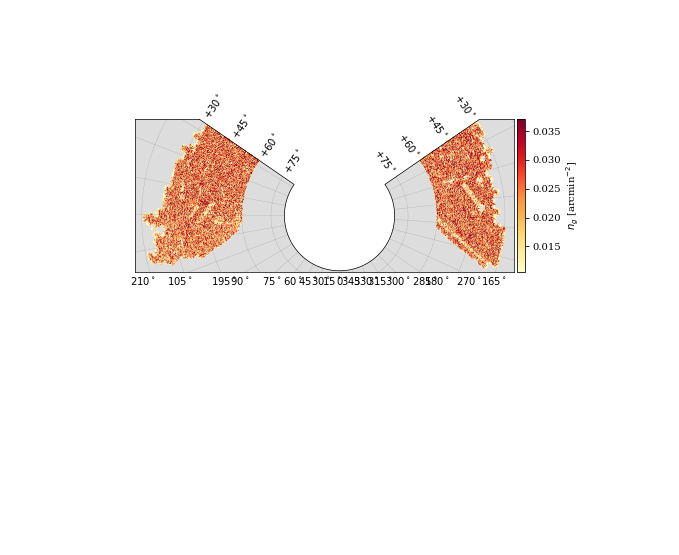

In [141]:
fig, ax = plt.subplots()


# # define the best Albers projection for the footprint
# # minimizing the variation in distortion
crit = skm.meanDistortion
proj = skm.Albers.optimize(dNGC['RA'], dNGC['DEC'], crit=crit)

# construct map: will hold figure and projection
# the outline of the sphere can be styled with kwargs for matplotlib Polygon
map = skm.Map(proj, interactive=False, ax=ax)

# add graticules, separated by 15 deg
# the lines can be styled with kwargs for matplotlib Line2D
# additional arguments for formatting the graticule labels
sep = 15
map.grid(sep=sep)

# # make density plot
nside = 256
mappable = map.density(dNGC['RA'], dNGC['DEC'], nside=nside)
cb = map.colorbar(mappable, cb_label="$n_g$ [arcmin$^{-2}$]")

# # add scatter plot
# # map.scatter(ra_scatter, dec_scatter, s=size_scatter, edgecolor='k', facecolor='None')

# # focus on relevant region#
map.focus(dNGC['RA'], dNGC['DEC'])


# map2 = map.clone()
# a,b = proj.distortion(dSGC['RA'], dSGC['DEC'])
# mappable2 = map2.hexbin(dSGC['RA'], dSGC['DEC'],
#                         C=1-np.abs(b/a), vmin=0, vmax=0.3, cmap='RdYlBu_r')
# cb2 = map2.colorbar(mappable2, cb_label='Distortion')
# map2.title('Projection distortion')
plt.tight_layout()
plt.savefig('ngc.png', bbox_inches='tight')

In [12]:
nside = 32
mappable = map.density(ra, dec, nside=nside)
cb = map.colorbar(mappable, cb_label="$n_g$ [arcmin$^{-2}$]")

/home/mehdi/github/skymapper/skymapper/map.py:810: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(pad=0.75)
/home/mehdi/github/skymapper/skymapper/map.py:1083: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(pad=0.75)


In [122]:
from LSSutils.utils import hpix2radec

In [125]:
radec = hpix2radec(nside, np.argwhere(mask).flatten())

In [133]:
help(dv.mollview)

Help on function mollview in module LSSutils.dataviz:

mollview(m, vmin, vmax, unit, use_mask=False, maskname=None, rotate=2.0943951023931953, xsize=1000, width=7, figax=None, colorbar=False, cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7fbc29ac1610>, galaxy=False, extend='both', **kwargs)
    (c)Andrea Zonca, https://github.com/zonca/paperplots 
    modified by Mehdi Rezaie for galaxy counts
    
    Matplotlib has higher freedom than healpy.mollview
    
    one could use rasterized=True to improve the quality
    for colorbar options, see
    https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.colorbar.html
    
    Example:
    
    unit = r'$\delta$'
    vmin = -0.5
    vmax = 0.5
    
    fig = plt.figure(figsize=(6, 7))
    # matplotlib is doing the mollveide projection
    ax  = fig.add_subplot(211, projection='mollweide')
    ax1 = fig.add_subplot(212, projection='mollweide')
    spacing = 0.01
    plt.subplots_adjust(bottom=spacing, top=1-spacing, 
     

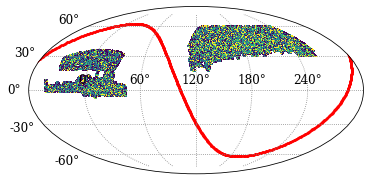

In [149]:
#plt.figure(figsize=(12, 8), projection='mollweide')

fig = plt.figure(figsize=(6, 7))
# matplotlib is doing the mollveide projection
ax  = fig.add_subplot(111, projection='mollweide')
#ax.scatter(shiftra(radec[0]), radec[1], 1, c=density[mask], vmin=30, vmax=130)
dv.mollview(density, vmin=30, vmax=130, figax=[fig, ax], unit='ng', cmap=plt.cm.viridis, galaxy=True)
ax.grid(ls=':', color='grey')